# Features Extraction

## Steps:
* Dense Optical Flow (using OpenCV - optical flow, optical strain, horizontal flow, vertical flow)
* Generation of face bounding box coordinates
* Cropping image
* Resizing image

In [1]:
import time
import cv2
import glob
import json
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Extraction of Onset and Apex Frames

In [27]:
emotions = ['anger', 'sadness', 'surprise', 'fear', 'happiness', 'disgust']

samm_annotation = '/mnt/d/DATASET/SAMM/SAMM_FACS.csv'
samm_df = pd.read_csv(samm_annotation)
samm_df.drop(labels=['Subject', 'Inducement Code',  'Micro', 'Objective Classes', 'Notes'], axis=1, inplace=True)
samm_df.rename(columns={ 'Onset Frame': 'OnsetFrame', 'Apex Frame': 'ApexFrame', 'Offset Frame': 'OffsetFrame' }, inplace=True)
samm_df['Subject'] = pd.Series([s.split('_')[0] for s in list(samm_df['Filename'])])
samm_df = samm_df[samm_df['Estimated Emotion'].str.lower().isin(emotions)]
samm_df = samm_df[['Subject', 'Filename', 'OnsetFrame', 'ApexFrame', 'OffsetFrame', 'Duration', 'Action Units', 'Estimated Emotion']]

mmew_annotation = '/mnt/d/DATASET/MMEW/MMEW_FACS.csv'
mmew_df = pd.read_csv(mmew_annotation)
mmew_df['Estimated Emotion'] = mmew_df['Estimated Emotion'].apply(lambda x: x.title())
mmew_df['Duration'] = mmew_df['OffsetFrame'] - mmew_df['OnsetFrame'] + 1
mmew_df.drop(labels=['remarks'], axis=1, inplace=True)
mmew_df = mmew_df[mmew_df['Estimated Emotion'].str.lower().isin(emotions)]
mmew_df = mmew_df[['Subject', 'Filename', 'OnsetFrame', 'ApexFrame', 'OffsetFrame', 'Duration', 'Action Units', 'Estimated Emotion']]

casme_ii_annotation = '/mnt/d/DATASET/CASME_II/CASME_II_FACS.csv'
casme_ii_df = pd.read_csv(casme_ii_annotation)
casme_ii_df['Subject'] = casme_ii_df['Subject'].apply(lambda x: f'sub{x:02d}')
casme_ii_df['Estimated Emotion'] = casme_ii_df['Estimated Emotion'].apply(lambda x: x.title())
casme_ii_df['Duration'] = casme_ii_df['OffsetFrame'] - casme_ii_df['OnsetFrame'] + 1
casme_ii_df = casme_ii_df[casme_ii_df['ApexFrame'] != '/']  # edge case
casme_ii_df = casme_ii_df[casme_ii_df['Estimated Emotion'].str.lower().isin(emotions)]
casme_ii_df = casme_ii_df[['Subject', 'Filename', 'OnsetFrame', 'ApexFrame', 'OffsetFrame', 'Duration', 'Action Units', 'Estimated Emotion']]

In [28]:
samm_df

,Subject,Filename,OnsetFrame,ApexFrame,OffsetFrame,Duration,Action Units,Estimated Emotion
0,006,006_1_2,5562,5588,5632,71,4+7,Anger
1,006,006_1_3,3912,3948,3988,77,4,Anger
2,006,006_1_4,2324,2368,2403,80,4+7,Anger
3,006,006_1_5,5343,5388,5424,82,4+7,Anger
4,006,006_1_6,7160,7197,7259,100,4+7+43,Anger
...,...,...,...,...,...,...,...,...
151,035,035_5_3,253,293,341,89,R20,Fear
152,035,035_6_3,180,210,236,57,R20B,Fear
153,035,035_7_1,7809,7819,7853,45,A1B+A2C,Surprise
155,036,036_7_3,2264,2339,2363,100,R10A+25+26,Disgust


In [29]:
mmew_df

,Subject,Filename,OnsetFrame,ApexFrame,OffsetFrame,Duration,Action Units,Estimated Emotion
0,1,S01-01-001,1,15,31,31,6+12,Happiness
1,1,S01-01-002,1,15,45,45,12,Happiness
2,1,S01-01-003,1,7,23,23,12,Happiness
3,1,S01-02-001,1,17,39,39,5,Surprise
4,1,S01-02-002,1,6,41,41,5,Surprise
...,...,...,...,...,...,...,...,...
290,30,S30-03-011,1,14,37,37,4+7,Disgust
291,30,S30-03-012,1,10,58,58,4+6+10,Disgust
297,30,S30-05-001,1,10,26,26,4+R20,Fear
298,30,S30-06-001,1,27,41,41,17,Sadness


In [30]:
casme_ii_df

,Subject,Filename,OnsetFrame,ApexFrame,OffsetFrame,Duration,Action Units,Estimated Emotion
0,sub06,EP01_01,81,111,136,56,L14,Happiness
1,sub07,EP01_01,79,109,156,78,4+R10,Disgust
3,sub19,EP01_01f,121,189,220,100,12,Happiness
4,sub12,EP01_02,31,99,106,76,4+10,Disgust
6,sub19,EP01_02f,36,61,127,92,12,Happiness
...,...,...,...,...,...,...,...,...
247,sub19,EP19_03,61,91,116,56,L1+L2,Surprise
250,sub19,EP19_04,46,69,86,41,L1,Sadness
252,sub01,EP19_05f,396,416,446,51,4+7+L10,Disgust
253,sub01,EP19_06f,36,71,161,126,4+7+L10,Disgust


In [31]:
data = {
    'dir': '/mnt/d/DATASET',
}

dbs = ['SAMM', 'MMEW', 'CASME_II']

In [32]:
def get_data(dir, db_name, emotion, data_dict):
    if db_name == 'SAMM':
        df = samm_df[samm_df['Estimated Emotion'].str.lower() == emotion]
        df_list = df.to_dict('records')

        image_path = f"{dir}/{db}/data"
        for d in df_list:
            onset_imgs = glob.glob(f"{image_path}/{d['Subject']}/{d['Filename']}/*{d['OnsetFrame']}.jpg")
            apex_imgs = glob.glob(f"{image_path}/{d['Subject']}/{d['Filename']}/*{d['ApexFrame']}.jpg")
            
            if len(onset_imgs) > 0:
                data_dict['onset'].append((f"s_{d['Subject']}", onset_imgs[0]))
            if len(apex_imgs) > 0:
                data_dict['apex'].append((f"s_{d['Subject']}", apex_imgs[0]))
    elif db_name == 'MMEW':
        df = mmew_df[mmew_df['Estimated Emotion'].str.lower() == emotion]
        df_list = df.to_dict('records')

        image_path = f"{dir}/{db}/data/{emotion}"
        for d in df_list:
            onset_imgs = glob.glob(f"{image_path}/{d['Filename']}/*{d['OnsetFrame']}.jpg")
            apex_imgs = glob.glob(f"{image_path}/{d['Filename']}/*{d['ApexFrame']}.jpg")
            
            if len(onset_imgs) > 0:
                data_dict['onset'].append((f"m_{d['Subject']}", onset_imgs[0]))
            if len(apex_imgs) > 0:
                data_dict['apex'].append((f"m_{d['Subject']}", apex_imgs[0]))
    elif db_name == 'CASME_II':
        df = casme_ii_df[casme_ii_df['Estimated Emotion'].str.lower() == emotion]
        df_list = df.to_dict('records')

        image_path = f"{dir}/{db}/data"
        for d in df_list:
            onset_imgs = glob.glob(f"{image_path}/{d['Subject']}/{d['Filename']}/img{d['OnsetFrame']}.jpg")
            apex_imgs = glob.glob(f"{image_path}/{d['Subject']}/{d['Filename']}/img{d['ApexFrame']}.jpg")
            
            if len(onset_imgs) > 0:
                data_dict['onset'].append((f"c_{d['Subject']}", onset_imgs[0]))
            if len(apex_imgs) > 0:
                data_dict['apex'].append((f"c_{d['Subject']}", apex_imgs[0]))

    data_dict['onset'] = list(set(data_dict['onset']))
    data_dict['apex'] = list(set(data_dict['apex']))
    data_dict['onset'] = sorted(data_dict['onset'], key=lambda x: x[1])
    data_dict['apex'] = sorted(data_dict['apex'], key=lambda x: x[1])
    
    return data_dict


for emotion in tqdm(emotions):
    if not emotion in data.keys(): 
        data[emotion] = {
            'onset': [],
            'apex': []
        }
    
    for db in dbs:
        data[emotion] = get_data(data['dir'], db, emotion, data[emotion].copy())

with open('../.data/onset_apex.json', 'w') as f:
    json.dump(data, f, indent=4)

100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


# Optical Flow

Configuration:
* Generating and saving face bounding box (SAMM and CASME II)

Source: 
* Optical Flow (TVL1Flow): http://www.ipol.im/pub/art/2013/26/
* Optical Strain: https://github.com/mariaoliverparera/mod-opticalStrain/blob/master/get_contours.py
* Horizontal and Vertical Components: https://stackoverflow.com/a/27644602
  * Gray: no motion
  * Black: maximum amount of motion (going to the left)
  * White: maximum amount of motion (going to the right)
* Facial Detection: https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81

In [33]:
with open('../.data/onset_apex.json') as f:
    data = json.load(f)

emotions = ['anger', 'sadness', 'surprise', 'fear', 'happiness', 'disgust']
dataset = {
    'dir': '/mnt/d/DATASET/MER_DATASET',
    'X': [],
    'y': []
}
face_bounding_box = {}

In [34]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def read_image(path):
    img = cv2.imread(path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray_img

def generate_optical_flow(index, path, db, emotion, subject, onset, apex):
    start_time = time.process_time()
    # compute optical flow (TVL1Flow)
    subprocess.check_call(f"bash ../run.sh '{onset}' '{apex}'", shell=True)
    end_time = time.process_time()
    print(f"{db} {emotion} {subject} {end_time - start_time}s")

    onset_img, onset_img_gray = read_image(onset)

    # creating mask based on the image
    hsv = np.zeros_like(onset_img)
    hsv[..., 1] = 255

    # reading optical flow
    flow = cv2.readOpticalFlow("flow.flo")

    # compute for the optical flow's magnitude and direction from the flow vector
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # compute for the horizontal and vertical components of the optical flow
    horz = cv2.normalize(flow[...,0], None, 0, 255, cv2.NORM_MINMAX)     
    vert = cv2.normalize(flow[...,1], None, 0, 255, cv2.NORM_MINMAX)
    horz = horz.astype('uint8')
    vert = vert.astype('uint8')

    # generate optical strain
    optical_strain = generate_optical_strain(flow)

    of_path = f"{path}/{index} {emotion} {subject} OF.jpg"
    os_path = f"{path}/{index} {emotion} {subject} OS.jpg"
    horz_path = f"{path}/{index} {emotion} {subject} H.jpg"
    vert_path = f"{path}/{index} {emotion} {subject} V.jpg"

    dataset['X'].append((of_path, os_path, horz_path, vert_path))
    dataset['y'].append(emotions.index(emotion))

    if db in ['SAMM', 'CASME_II']:
        x, y, w, h = generate_bounding_box(onset_img_gray)
        face_bounding_box[of_path] = (x, y, w, h)
        face_bounding_box[os_path] = (x, y, w, h)
        face_bounding_box[horz_path] = (x, y, w, h)
        face_bounding_box[vert_path] = (x, y, w, h)

    cv2.imwrite(of_path, rgb)
    cv2.imwrite(os_path, optical_strain)
    cv2.imwrite(horz_path, horz)
    cv2.imwrite(vert_path, vert)

def generate_optical_strain(flow):
    u = flow[...,0]
    v = flow[...,1]

    ux, uy = np.gradient(u)
    vx, vy = np.gradient(v)

    e_xy = 0.5*(uy + vx)
    e_xx = ux
    e_yy = vy
    e_m = e_xx ** 2 + 2 * e_xy ** 2 + e_yy ** 2
    e_m = np.sqrt(e_m)
    e_m = cv2.normalize(e_m, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    e_m = e_m.astype(np.uint8)
    
    return e_m

def generate_bounding_box(gray_img):
    faces = face_cascade.detectMultiScale(gray_img, 1.1, 4)
    x, y, w, h = faces[0]
    return str(x), str(y), str(w), str(h)

In [35]:
emotions = ['anger', 'sadness', 'surprise', 'fear', 'happiness', 'disgust']

for expr in emotions:
    for i, (onset, apex) in enumerate(zip(data[expr]['onset'], data[expr]['apex'])):
        subject = onset[0] or apex[0]

        if 'SAMM' in onset[1] or 'SAMM' in apex[1]:
            db = 'SAMM'
        elif 'MMEW' in onset[1] or 'MMEW' in apex[1]:
            db = 'MMEW'
        elif 'CASME_II' in onset[1] or 'CASME_II' in apex[1]:
            db = 'CASME_II'

        print(f"{expr} - ({i+1}/{len(data[expr]['onset'])})", end=' | ')
        generate_optical_flow(i+1, f"{dataset['dir']}/{db}", db, expr, subject, onset[1], apex[1])

with open('../.data/dataset.json', 'w') as f:
    json.dump(dataset, f, indent=4)

with open('../.data/face_bounding_box.json', 'w') as f:
    json.dump(face_bounding_box, f, indent=4)

MMEW anger m_13 0.007945500000001715s
MMEW anger m_17 0.004723499999997216s
MMEW anger m_17 0.003007700000001279s
MMEW anger m_18 0.003201899999996982s
MMEW anger m_18 0.0031189000000004796s
MMEW anger m_18 0.004085199999998679s
MMEW anger m_25 0.003573100000000551s
MMEW anger m_28 0.005813799999998537s
SAMM anger s_006 0.004125799999997071s
SAMM anger s_006 0.004771899999997942s
SAMM anger s_006 0.00561569999999989s
SAMM anger s_006 0.004244299999999868s
SAMM anger s_006 0.005318599999998952s
SAMM anger s_006 0.0042642999999991105s
SAMM anger s_006 0.004673300000000324s
SAMM anger s_009 0.004912999999998391s
SAMM anger s_009 0.0047827999999974224s
SAMM anger s_010 0.004396400000000966s
SAMM anger s_010 0.0043416000000000565s
SAMM anger s_010 0.004410899999999884s
SAMM anger s_010 0.00471019999999811s
SAMM anger s_011 0.004686700000000599s
SAMM anger s_011 0.0041504999999979475s
SAMM anger s_011 0.00419639999999788s
SAMM anger s_011 0.004643699999999029s
SAMM anger s_011 0.004368200000

# Cropping and Resizing Images

Configuration:
* Cropping the image to focus on the face
* Resize all images to one uniform dimension (128 x 128)

Source:
* Cropping Image: https://www.geeksforgeeks.org/cropping-faces-from-images-using-opencv-python/
* Resizing Image: https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/

In [ ]:
with open('../.data/dataset.json') as f:
    dataset = json.load(f)

with open('../.data/face_bounding_box.json') as f:
    face_bounding_box = json.load(f)

In [37]:
def crop_resize_image(path, img, x, y, w, h, dim, crop=True):
    if crop:
        cropped_image = img[y:y+h, x:x+w]
        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
        cv2.imwrite(path, resized_image)
    else:
        resized_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        cv2.imwrite(path, resized_image)

In [38]:
dim = (128, 128)

for (OF, OS, H, V) in tqdm(dataset['X']):
    if 'SAMM' in OF or 'CASME_II' in OF:
        crop = True

        img = cv2.imread(OF)
        x, y, w, h = face_bounding_box[OF]
        crop_resize_image(OF, img, int(x), int(y), int(w), int(h), dim, crop)
        img = cv2.imread(OS)
        x, y, w, h = face_bounding_box[OS]
        crop_resize_image(OS, img, int(x), int(y), int(w), int(h), dim, crop)
        img = cv2.imread(H)
        x, y, w, h = face_bounding_box[H]
        crop_resize_image(H, img, int(x), int(y), int(w), int(h), dim, crop)
        img = cv2.imread(V)
        x, y, w, h = face_bounding_box[V]
        crop_resize_image(V, img, int(x), int(y), int(w), int(h), dim, crop)
    elif 'MMEW' in OF:
        crop = False

        img = cv2.imread(OF)
        crop_resize_image(OF, img, None, None, None, None, dim, crop)
        img = cv2.imread(OS)
        crop_resize_image(OS, img, None, None, None, None, dim, crop)
        img = cv2.imread(H)
        crop_resize_image(H, img, None, None, None, None, dim, crop)
        img = cv2.imread(V)
        crop_resize_image(V, img, None, None, None, None, dim, crop)
        

100%|██████████| 483/483 [00:17<00:00, 27.26it/s]


# SCRATCH

In [6]:
with open('../.data/onset_apex.json') as f:
    data = json.load(f)

dataset = {
    'X': [],
    'y': []
}

face_bounding_box = {}

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def read_image(path):
    img = cv2.imread(path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray_img

def generate_optical_flow(onset, apex):
    # compute optical flow (TVL1Flow)
    subprocess.check_call(f"bash ../run.sh '{onset}' '{apex}'", shell=True)
    end_time = time.process_time()

    onset_img, onset_img_gray = read_image(onset)

    # creating mask based on the image
    hsv = np.zeros_like(onset_img)
    hsv[..., 1] = 255

    # reading optical flow
    flow = cv2.readOpticalFlow("flow.flo")

    # compute for the optical flow's magnitude and direction from the flow vector
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # compute for the horizontal and vertical components of the optical flow
    horz = cv2.normalize(flow[...,0], None, 0, 255, cv2.NORM_MINMAX)     
    vert = cv2.normalize(flow[...,1], None, 0, 255, cv2.NORM_MINMAX)
    horz = horz.astype('uint8')
    vert = vert.astype('uint8')

    # generate optical strain
    optical_strain = generate_optical_strain(flow)

    x, y, w, h = generate_bounding_box(onset_img_gray)

    return rgb, optical_strain, horz, vert, x, y, w, h

def generate_optical_strain(flow):
    u = flow[...,0]
    v = flow[...,1]

    ux, uy = np.gradient(u)
    vx, vy = np.gradient(v)

    e_xy = 0.5*(uy + vx)
    e_xx = ux
    e_yy = vy
    e_m = e_xx ** 2 + 2 * e_xy ** 2 + e_yy ** 2
    e_m = np.sqrt(e_m)
    e_m = cv2.normalize(e_m, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    e_m = e_m.astype(np.uint8)
    
    return e_m

def generate_bounding_box(gray_img):
    faces = face_cascade.detectMultiScale(gray_img, 1.1, 4)
    x, y, w, h = faces[0]
    return str(x), str(y), str(w), str(h)

In [8]:
onset = data['anger']['onset'][8]
apex = data['anger']['apex'][8]

onset, apex

(['s_006', '/mnt/d/DATASET/SAMM/data/006/006_1_2/006_05562.jpg'],
 ['s_006', '/mnt/d/DATASET/SAMM/data/006/006_1_2/006_05588.jpg'])

In [9]:
rgb, optical_strain, horz, vert, x, y, w, h = generate_optical_flow(onset[1], apex[1])

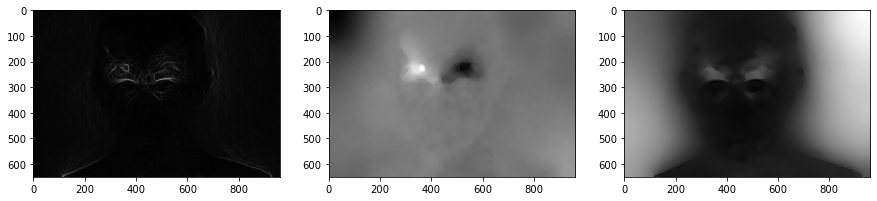

205 118 463 463


In [10]:
cv2.imwrite('optical_strain.png', optical_strain)
cv2.imwrite('horz.png', horz)
cv2.imwrite('vert.png', vert)

fix, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(optical_strain, cmap='gray')
ax[1].imshow(horz, cmap='gray')
ax[2].imshow(vert, cmap='gray')
plt.show()

x, y, w, h = int(x), int(y), int(w), int(h)
print(x, y, w, h)

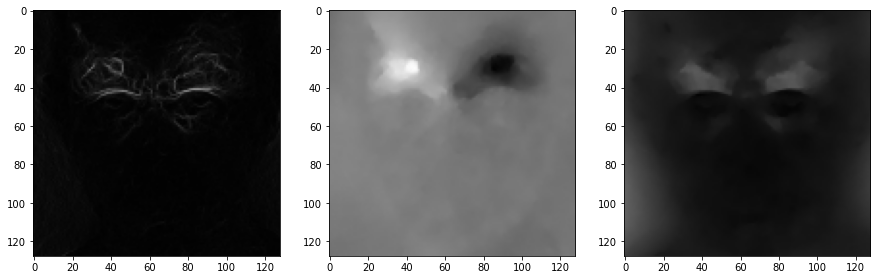

In [11]:
optical_strain = cv2.imread('optical_strain.png')
cropped_image = optical_strain[y:y+h, x:x+w]
optical_strain = cv2.resize(cropped_image, (128, 128), interpolation=cv2.INTER_AREA)

horz = cv2.imread('horz.png')
cropped_image = horz[y:y+h, x:x+w]
horz = cv2.resize(cropped_image, (128, 128), interpolation=cv2.INTER_AREA)

vert = cv2.imread('vert.png')
cropped_image = vert[y:y+h, x:x+w]
vert = cv2.resize(cropped_image, (128, 128), interpolation=cv2.INTER_AREA)

fix, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(optical_strain, cmap='gray')
ax[1].imshow(horz, cmap='gray')
ax[2].imshow(vert, cmap='gray')
plt.show()